# A Meal's True Cost

The main goal of this Exploratory Data Analysis is to understand the environmental impact of each product we choose to eat and, therefore, the impact of our meals. By knowing this, we can change our consumption habits and improve our planet's health.
We'll start from a broad perspective, analyzing the general impact of food production on a worldwide scale in the form of water withdrawal, gas emissions and land use and comparing it to the impact of other industries. Then, we'll move to a specific country, Italy, to study the consumption habits of the citizens and the environmental effects caused by the top 15 consumed products.

In [51]:
import pandas as pd
from fuzzywuzzy import process, fuzz
import re
import matplotlib.pyplot as plt
import numpy as np

## Getting and parsing the data

Firstly, we are going to parse the data we have. In this case, the main sources are:
- the FAO AQUASTAT database for information about worldwide water withdrawal
- the EFSA (European Food Safety Authority) food consumption data for data about the consumption of different types of food in various countries
- the data about water footprint of the watertofood project (part of the bigger CWASI dataset).
- land use data from FAOSTAT
- greenhouse gas emissions data from Climate Watch

In [52]:
# Load the data on worldwide water withdrawals

world_water_data = pd.read_csv("data/aquastat_world_water_data.csv", encoding="utf-8")
world_water_data.head(5)

,VariableGroup,Subgroup,Variable,Area,Year,Value,Unit,Symbol,IsAggregate
0,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2000,16.711086,10^9 m3/year,E,True
1,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2001,16.822571,10^9 m3/year,E,True
2,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2002,16.330557,10^9 m3/year,E,True
3,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2003,15.838543,10^9 m3/year,E,True
4,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2004,15.346529,10^9 m3/year,E,True


In [53]:
# Load the food consumption data
food_consumption_data = pd.read_csv("data/chronic_consumption_gday_allsubjects.csv", encoding="utf-16")
food_consumption_data.head(5)

,Survey's country,Survey start year,Survey name,Population Group (L2),Exposure hierarchy (L1),Exposure hierarchy (L2),Exposure hierarchy (L3),Exposure hierarchy (L4),Exposure hierarchy (L5),Exposure hierarchy (L6),...,Number of consumers,Mean,Standard Deviation,5th percentile,10th percentile,Median,95th percentile,97.5th percentile,99th percentile,Comment
0,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Beer and beer-like beverage,Beer,Beer,Beer,Beer,...,9,8.40,79.01,0.0,0.0,0.0,0.00,7.88,165.00,"'Number of observations lower than 298, the 99..."
1,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Unsweetened spirits and liqueurs,Liqueurs,Liqueurs,Liqueurs,Liqueurs,...,2,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
2,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Unsweetened spirits and liqueurs,Unsweetened spirits,Spirits from fruit,Spirits made from fruits other than stone fruits,Spirits made from fruits other than stone fruits,...,1,0.05,0.75,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
3,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,Sparkling wine,Sparkling wine,Sparkling wine,...,1,0.08,1.28,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
4,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,"Wine, red","Wine, red","Wine, red",...,16,1.19,15.21,0.0,0.0,0.0,0.09,0.12,2.96,"'Number of observations lower than 298, the 99..."


In [54]:
# Load the water to food data (no-animal)
watertofood_data = pd.read_csv("data/watertofood_data_italy.csv", encoding="utf-8", sep=";")
watertofood_data.columns = watertofood_data.columns.map(str)
watertofood_data.head(5)

,Country Name,Country FAO Code,Country ISO2,Item Name,Item FAO Code,Item Category,Unit of Measure,1986,1987,1988,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Italy,106,IT,Wheat,15,Cereals,m3/ton,1192.040039,1180.640015,1278.810059,...,1152.670044,1017.260010,1069.989990,1055.760010,1025.219971,1006.349976,965.919983,966.867004,997.875000,945.799011
1,Italy,106,IT,Flour of Wheat,16,Cereals,m3/ton,1206.209961,1194.670044,1294.020020,...,1166.369995,1029.349976,1082.709961,1068.319946,1206.209961,1194.670044,1294.020020,1306.260010,1208.140015,1000.450012
2,Italy,106,IT,Macaroni,18,Cereals,m3/ton,1206.209961,1194.670044,1294.020020,...,1166.369995,1029.349976,1082.709961,1068.319946,1206.209961,1194.670044,1294.020020,1306.260010,1208.140015,1000.450012
3,Italy,106,IT,Bread,20,Cereals,m3/ton,1048.880005,1038.849976,1125.229980,...,1014.239990,895.086975,941.487000,928.971008,1048.880005,1038.849976,1125.229980,1135.880005,1050.550049,869.960022
4,Italy,106,IT,Bulgur,21,Cereals,m3/ton,1328.510010,1315.810059,1425.219971,...,1284.640015,1133.719971,1192.489990,1176.640015,1328.510010,1315.810059,1425.219971,1438.709961,1330.640015,1101.890015


In [55]:
# loading dataset on water consumption for animal products
watertofood_animals = pd.read_csv("data/watertofood_data_italy_animal.csv", encoding="utf-8", sep=";")
watertofood_animals.columns = watertofood_animals.columns.map(str)
watertofood_animals.head(5)

,Country Name,Country FAO Code,Country ISO2,Item Name,Item FAO Code,Item Category,Unit of Measure,Value
0,Italy,106,IT,Cattle,866,Live animals,m3/ton,5094.3
1,Italy,106,IT,Cattle meat,867,Meat,m3/ton,7521.7
2,Italy,106,IT,"Offals of cattle, edible",868,Meat,m3/ton,7605.0
3,Italy,106,IT,"Fat, cattle",869,Meat,m3/ton,7605.0
4,Italy,106,IT,"Meat-Cattle, boneless",870,Meat,m3/ton,10596.7


In [56]:
# loading dataset on land use
landuse_data = pd.read_csv("data/FAOSTAT_land_use_data.csv", encoding="utf-8")
landuse_data.head(10)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,RL,Land Use,1,World,5110,Area,6600,Country area,1999,1999,1000 ha,1.401384e+07,A,Official figure,NaN
1,RL,Land Use,1,World,5110,Area,6600,Country area,2000,2000,1000 ha,1.401354e+07,A,Official figure,NaN
2,RL,Land Use,1,World,5110,Area,6600,Country area,2001,2001,1000 ha,1.401358e+07,A,Official figure,NaN
3,RL,Land Use,1,World,5110,Area,6600,Country area,2002,2002,1000 ha,1.401362e+07,A,Official figure,NaN
4,RL,Land Use,1,World,5110,Area,6600,Country area,2003,2003,1000 ha,1.401367e+07,A,Official figure,NaN
5,RL,Land Use,1,World,5110,Area,6600,Country area,2004,2004,1000 ha,1.401708e+07,A,Official figure,NaN
6,RL,Land Use,1,World,5110,Area,6600,Country area,2005,2005,1000 ha,1.401728e+07,A,Official figure,NaN
7,RL,Land Use,1,World,5110,Area,6600,Country area,2006,2006,1000 ha,1.401731e+07,A,Official figure,NaN
8,RL,Land Use,1,World,5110,Area,6600,Country area,2007,2007,1000 ha,1.401732e+07,A,Official figure,NaN
9,RL,Land Use,1,World,5110,Area,6600,Country area,2008,2008,1000 ha,1.403727e+07,A,Official figure,NaN


In [57]:
# Load the dataset on greehhouse gas emissions
ghg_emissions_data = pd.read_csv("data/historical_emissions.csv", encoding="utf-8")
ghg_emissions_data.head(10)

,ISO,Country,Data source,Sector,Gas,Unit,2022,2021,2020,2019,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,WORLD,World,Climate Watch,Total including LUCF,All GHG,MtCO₂e,50122.98,49656.95,47566.60,49867.66,...,35641.67,35644.87,36105.39,34738.96,34342.37,33543.05,33266.46,33115.40,33203.66,33027.00
1,WORLD,World,Climate Watch,Total excluding LUCF,All GHG,MtCO₂e,48824.22,48312.38,46169.76,48070.69,...,33706.46,33518.55,33308.86,32911.93,32311.95,31518.25,31241.32,31090.69,31178.95,31002.30
2,WORLD,World,Climate Watch,Energy,All GHG,MtCO₂e,38008.54,37497.65,35532.26,37623.18,...,25826.94,25701.94,25543.82,25119.71,24605.32,23943.99,23845.95,23707.42,23818.01,23660.14
3,WORLD,World,Climate Watch,Electricity/Heat,All GHG,MtCO₂e,16688.42,16447.75,15323.08,15843.06,...,10226.32,10163.84,9937.03,9662.55,9296.41,9105.35,9003.81,8953.47,8796.23,8653.37
4,CHN,China,Climate Watch,Total excluding LUCF,All GHG,MtCO₂e,13363.49,13354.71,12755.05,12620.91,...,4479.82,4547.84,4431.16,4435.17,4414.00,4015.37,3857.88,3628.70,3499.72,3351.43
5,CHN,China,Climate Watch,Total including LUCF,All GHG,MtCO₂e,12715.91,12707.32,12107.80,11973.63,...,4134.06,4202.18,4085.27,4089.20,4067.55,3668.88,3511.39,3282.21,3153.23,3004.93
6,CHN,China,Climate Watch,Energy,All GHG,MtCO₂e,11308.84,11245.66,10657.18,10566.75,...,3343.80,3447.66,3361.39,3306.30,3335.37,3011.47,2901.54,2685.77,2588.40,2473.07
7,WORLD,World,Climate Watch,Transportation,All GHG,MtCO₂e,8151.42,7853.20,7283.00,8497.70,...,5738.55,5574.08,5447.53,5369.33,5159.12,5021.55,4923.23,4880.23,4772.10,4733.71
8,CHN,China,Climate Watch,Electricity/Heat,All GHG,MtCO₂e,6481.75,6288.27,5714.21,5618.65,...,1439.69,1416.39,1334.53,1336.76,1191.43,1088.00,1002.36,881.91,798.08,728.78
9,WORLD,World,Climate Watch,Manufacturing/Construction,All GHG,MtCO₂e,6303.94,6349.21,6202.69,6248.09,...,3703.74,3861.00,3862.91,3838.82,3956.48,3732.51,3719.10,3770.69,3900.00,3978.52


In [58]:
fao_greenhouse_gas_emissions = pd.read_csv("data/FAOSTAT_emissions_total.csv", encoding="utf-8")
fao_greenhouse_gas_emissions.head(10)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Source Code,Source,Unit,Value,Flag,Flag Description,Note
0,GT,Emissions totals,1,World,7234,Direct emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,425.3989,E,Estimated value,NaN
1,GT,Emissions totals,1,World,7236,Indirect emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,95.7152,E,Estimated value,NaN
2,GT,Emissions totals,1,World,7230,Emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,521.1148,E,Estimated value,NaN
3,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN
4,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN
5,GT,Emissions totals,1,World,7234,Direct emissions (N2O),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,423.9805,E,Estimated value,NaN
6,GT,Emissions totals,1,World,7236,Indirect emissions (N2O),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,95.3954,E,Estimated value,NaN
7,GT,Emissions totals,1,World,7230,Emissions (N2O),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,519.3763,E,Estimated value,NaN
8,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,137634.7195,E,Estimated value,NaN
9,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,137634.7195,E,Estimated value,NaN


## Worldwide impact of food production
### How much water is used to produce food?

In [59]:
unique_variables = world_water_data['Variable'].unique()

print(unique_variables)

['Agricultural water withdrawal'
 'Agricultural water withdrawal as % of total water withdrawal'
 'Agricultural water withdrawal per capita'
 'Environmental Flow Requirements' 'Industrial water withdrawal'
 'Industrial water withdrawal as % of total water withdrawal'
 'Industrial water withdrawal per capita' 'Irrigation water requirement'
 'Irrigation water withdrawal' 'Municipal water withdrawal'
 'Municipal water withdrawal as % of total withdrawal'
 'Municipal water withdrawal per capita (total population)'
 'Total water withdrawal' 'Total water withdrawal per capita'
 'Water withdrawal for aquaculture'
 'Water withdrawal for livestock (watering and cleaning)']


In [60]:
# Define the variables of interest
variables_of_interest = [
    "Agricultural water withdrawal",
    "Industrial water withdrawal",
    "Municipal water withdrawal"
]

# Filter the dataframe
filtered = world_water_data[
    (world_water_data["Variable"].isin(variables_of_interest)) &
    (world_water_data["Year"] == 2022) &
    (world_water_data["Area"] == "World")
]

# Extract lists
selected_variables = filtered["Variable"].tolist()
selected_values = filtered["Value"].tolist()

print(filtered["Value"].sum())
print("Selected Variables:", selected_variables)
print("Selected Values:", selected_values)

3988.7171439719996
Selected Variables: ['Agricultural water withdrawal', 'Industrial water withdrawal', 'Municipal water withdrawal']
Selected Values: [2851.590176077, 609.893920192, 527.233047703]


In [61]:
unit_of_measurement = world_water_data[(world_water_data["Variable"] == "Agricultural water withdrawal")]["Unit"].values[0]
print("Unit of Measurement:", unit_of_measurement)

Unit of Measurement: 10^9 m3/year


In [62]:
labels = selected_variables
sizes = selected_values

Text(0.5, 1.0, 'Water Withdrawal by Sector in 2022 (World)')

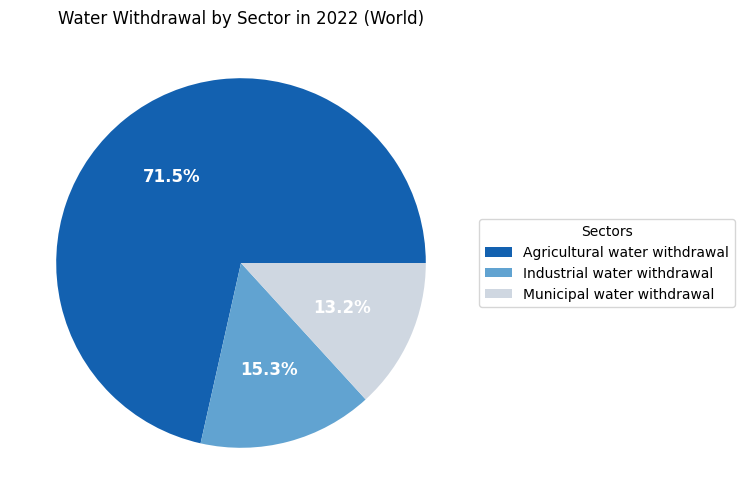

In [63]:
colors = ["#1361B0", "#61A3D1", "#CFD7E1"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

data = selected_values
labels = selected_variables

# Add autopct to display percentages inside the pie
wedges, texts, autotexts = ax.pie(
    data,
    colors=colors,
    textprops=dict(color="w"),
    autopct='%1.1f%%'  # This adds the percentage labels
)

ax.legend(wedges, labels,
          title="Sectors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(texts, size=12, weight="bold")
plt.setp(autotexts, size=12, weight="bold")  # Style the percentage labels

ax.set_title("Water Withdrawal by Sector in 2022 (World)")

### How much land is it used for food production?

In [64]:
filter_landuse_data = landuse_data["Item"].unique()
print("Unique Land Use Items:", filter_landuse_data)

Unique Land Use Items: ['Country area' 'Land area' 'Agriculture' 'Agricultural land' 'Cropland'
 'Arable land' 'Temporary crops' 'Temporary meadows and pastures'
 'Temporary fallow' 'Permanent crops' 'Permanent meadows and pastures'
 'Forest land' 'Naturally regenerating forest' 'Planted Forest'
 'Other land' 'Inland waters' 'Land area equipped for irrigation'
 'Agriculture area under organic agric.' 'Primary Forest']


In [65]:
# Filter the land use data
filtered_landuse = landuse_data[
    (landuse_data["Area"] == "World") &
    (landuse_data["Year"] == 2018) &
    (landuse_data["Element"] == "Area") &
    (landuse_data["Item"].isin(["Country land",
                                "Land area", 
                                "Agriculture", 
                                "Forest land", 
                                "Land used for aquaculture", 
                                "Inland waters used for aquac. or holding facilities", 
                                "Inland waters used for capture fishes", 
                                "Coastal waters used for aquac. or holding facilities",
                                "Coastal waters used for capture fishes",
                                "EEZ used for aquac. or holding facilities",
                                "EEZ used for capture fishes"]))
]

filtered_landuse = filtered_landuse[["Area", "Year", "Item", "Value"]]
filtered_landuse

,Area,Year,Item,Value
44,World,2018,Land area,1.303152e+07
69,World,2018,Agriculture,4.841329e+06
532,World,2018,Forest land,4.068924e+06


In [66]:
land_area = filtered_landuse[(filtered_landuse["Item"] == "Land area")]["Value"].iloc[0]
agriculture_area = filtered_landuse[(filtered_landuse["Item"] == "Agriculture")]["Value"].iloc[0]
forest_land_area = filtered_landuse[(filtered_landuse["Item"] == "Forest land")]["Value"].iloc[0]
other_land_area = land_area - (agriculture_area + forest_land_area)

# percentage of land used for agriculture
agriculture_percentage = (agriculture_area / land_area) * 100
forest_land_area_percentage = (forest_land_area / land_area) * 100
other_land_area_percentage = (other_land_area / land_area) * 100
print(f"Percentage of land used for agriculture: {agriculture_percentage:.2f}%")
print(f"Percentage of land used for forest: {forest_land_area_percentage:.2f}%")
print(f"Percentage of other land use: {other_land_area_percentage:.2f}%")

Percentage of land used for agriculture: 37.15%
Percentage of land used for forest: 31.22%
Percentage of other land use: 31.63%


Text(0.5, 1.0, 'Land use by Sector in 2022 (World)')

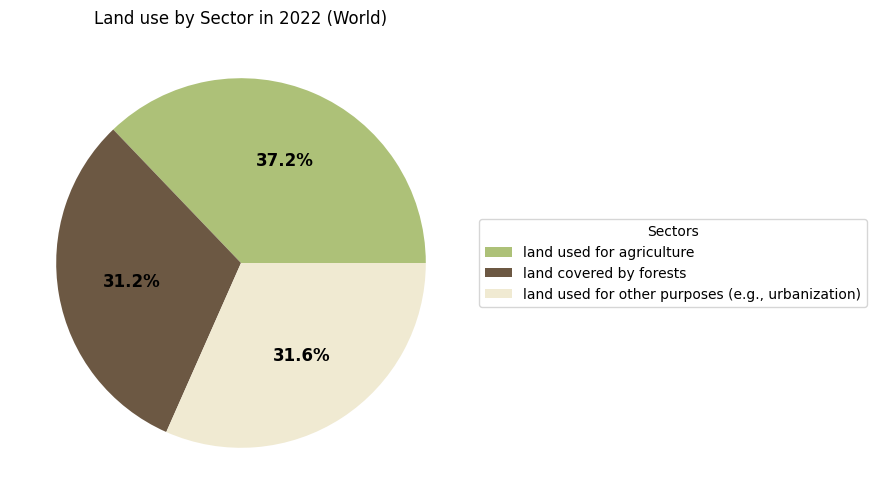

In [67]:
labels = ["land used for agriculture", "land covered by forests", "land used for other purposes (e.g., urbanization)"]
sizes = [agriculture_area, forest_land_area, other_land_area]
colors = ["#ADC178", "#6C5843", "#F0EAD2"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

data = sizes

# Add autopct to display percentages inside the pie
wedges, texts, autotexts = ax.pie(
    data,
    colors=colors,
    autopct='%1.1f%%'  # This adds the percentage labels
)

ax.legend(wedges, labels,
          title="Sectors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(texts, size=12, weight="bold")
plt.setp(autotexts, size=12, weight="bold")  # Style the percentage labels

ax.set_title("Land use by Sector in 2022 (World)")

### What are the emissions of the agricultural sector compared to other sectors?

In [68]:
ghg_emissions_data

,ISO,Country,Data source,Sector,Gas,Unit,2022,2021,2020,2019,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,WORLD,World,Climate Watch,Total including LUCF,All GHG,MtCO₂e,50122.98,49656.95,47566.60,49867.66,...,35641.67,35644.87,36105.39,34738.96,34342.37,33543.05,33266.46,33115.40,33203.66,33027.00
1,WORLD,World,Climate Watch,Total excluding LUCF,All GHG,MtCO₂e,48824.22,48312.38,46169.76,48070.69,...,33706.46,33518.55,33308.86,32911.93,32311.95,31518.25,31241.32,31090.69,31178.95,31002.30
2,WORLD,World,Climate Watch,Energy,All GHG,MtCO₂e,38008.54,37497.65,35532.26,37623.18,...,25826.94,25701.94,25543.82,25119.71,24605.32,23943.99,23845.95,23707.42,23818.01,23660.14
3,WORLD,World,Climate Watch,Electricity/Heat,All GHG,MtCO₂e,16688.42,16447.75,15323.08,15843.06,...,10226.32,10163.84,9937.03,9662.55,9296.41,9105.35,9003.81,8953.47,8796.23,8653.37
4,CHN,China,Climate Watch,Total excluding LUCF,All GHG,MtCO₂e,13363.49,13354.71,12755.05,12620.91,...,4479.82,4547.84,4431.16,4435.17,4414.00,4015.37,3857.88,3628.70,3499.72,3351.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,SOM,Somalia,Climate Watch,Other Fuel Combustion,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,...,0.05,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.07
2656,TON,Tonga,Climate Watch,Other Fuel Combustion,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2657,TTO,Trinidad and Tobago,Climate Watch,Other Fuel Combustion,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.04,NaN,NaN
2658,UKR,Ukraine,Climate Watch,Bunker Fuels,All GHG,MtCO₂e,NaN,0.17,0.10,0.38,...,0.89,0.66,0.87,0.89,0.48,0.58,0.94,2.20,5.62,6.23


In [69]:
unique_sectors = ghg_emissions_data['Sector'].unique().tolist()
print("Unique sectors in GHG emissions data:" + str(unique_sectors))

Unique sectors in GHG emissions data:['Total including LUCF', 'Total excluding LUCF', 'Energy', 'Electricity/Heat', 'Transportation', 'Manufacturing/Construction', 'Agriculture', 'Industrial Processes', 'Building', 'Fugitive Emissions', 'Waste', 'Land-Use Change and Forestry', 'Bunker Fuels', 'Other Fuel Combustion']


In [70]:
ghg_emissions_agriculture = ghg_emissions_data[
    (ghg_emissions_data["Sector"] == "Agriculture") &
    (ghg_emissions_data["Country"] == "World")]["2022"]
ghg_emissions_agriculture
    

10    5905.6
Name: 2022, dtype: float64

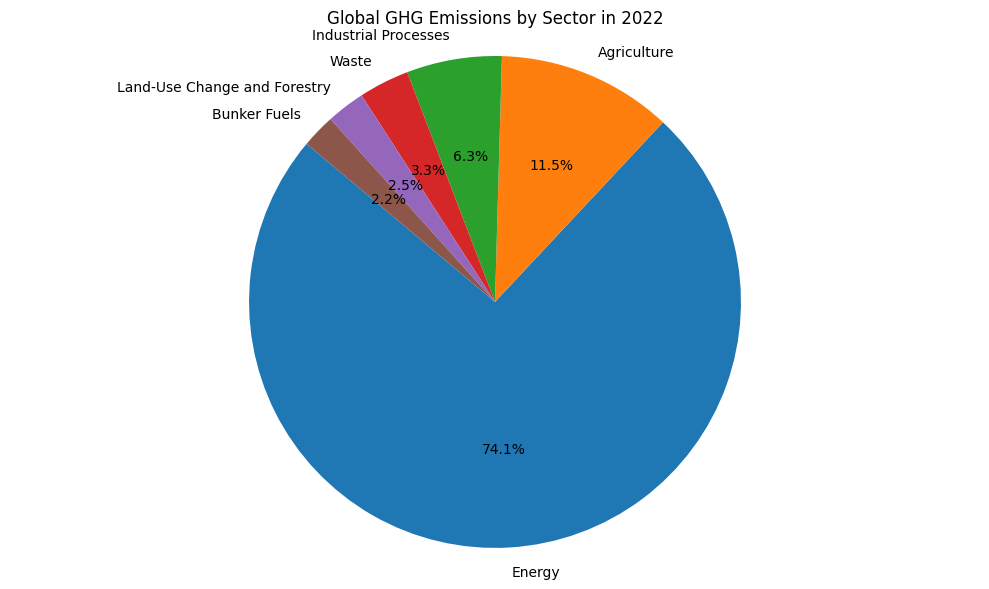

In [71]:
sectors = ["Energy", "Agriculture", "Industrial Processes", "Waste", "Bunker Fuels", "Land-Use Change and Forestry"]

ghg_without_total = ghg_emissions_data[(ghg_emissions_data["Country"] == "World") & (ghg_emissions_data["Sector"].isin(sectors))]
ghg_total_emissions_2022 = ghg_without_total["2022"].sum()

list_of_sectors = []
list_of_emissions_percentages = []

for row in ghg_without_total.iterrows():
    sector = row[1]["Sector"]
    emissions = row[1]["2022"]
    percentage = (emissions / ghg_total_emissions_2022) * 100
    list_of_sectors.append(sector)
    list_of_emissions_percentages.append(percentage)

# Plotting a pie chart of GHG emissions by sector
plt.figure(figsize=(10, 6))
plt.pie(list_of_emissions_percentages, labels=list_of_sectors, autopct='%1.1f%%', startangle=140)
plt.title("Global GHG Emissions by Sector in 2022")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.tight_layout()
plt.show()

### What are the emissions of the different processes carried out in the food sector?

In [72]:
fao_greenhouse_gas_emissions

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Source Code,Source,Unit,Value,Flag,Flag Description,Note
0,GT,Emissions totals,1,World,7234,Direct emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,425.3989,E,Estimated value,NaN
1,GT,Emissions totals,1,World,7236,Indirect emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,95.7152,E,Estimated value,NaN
2,GT,Emissions totals,1,World,7230,Emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,521.1148,E,Estimated value,NaN
3,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN
4,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,GT,Emissions totals,1,World,7230,Emissions (N2O),6819,Other,2022,2022,3050,FAO TIER 1,kt,601.7354,E,Estimated value,NaN
3620,GT,Emissions totals,1,World,7273,Emissions (CO2),6819,Other,2022,2022,3050,FAO TIER 1,kt,47500.3188,E,Estimated value,NaN
3621,GT,Emissions totals,1,World,724413,Emissions (CO2eq) from CH4 (AR5),6819,Other,2022,2022,3050,FAO TIER 1,kt,4218.9272,E,Estimated value,NaN
3622,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),6819,Other,2022,2022,3050,FAO TIER 1,kt,159459.8941,E,Estimated value,NaN


In [73]:
fao_greenhouse_gas_emissions["Element"].unique()

array(['Direct emissions (N2O)', 'Indirect emissions (N2O)',
       'Emissions (N2O)', 'Emissions (CO2eq) from N2O (AR5)',
       'Emissions (CO2eq) (AR5)', 'Emissions (CH4)',
       'Emissions (CO2eq) from CH4 (AR5)', 'Emissions (CO2)',
       'Emissions (CO2eq) from F-gases (AR5)'], dtype=object)

In [75]:
items_no_interest = [
    "Energy", "IPPU, Waste", "International bunkers", "Other"
]

In [ ]:
useful_elements = [
    "Emissions (CO2eq) from N2O (AR5)",
    "Emissions (CO2eq) (AR5)",
    "Emissions (CO2eq) from CH4 (AR5)",
    "Emissions (CO2)",
    "Emissions (CO2eq) from F-gases (AR5)",
]

filtered_fao_emissions = fao_greenhouse_gas_emissions[(fao_greenhouse_gas_emissions["Element"] == useful_elements[1]) &
                                                      (fao_greenhouse_gas_emissions["Area"] == "World") & 
                                                      (fao_greenhouse_gas_emissions["Year"] == 2022)]

filtered_fao_emissions = filtered_fao_emissions.reset_index(drop=True)

filtered_fao_emissions

## Which are the most consumed types of food in Italy?

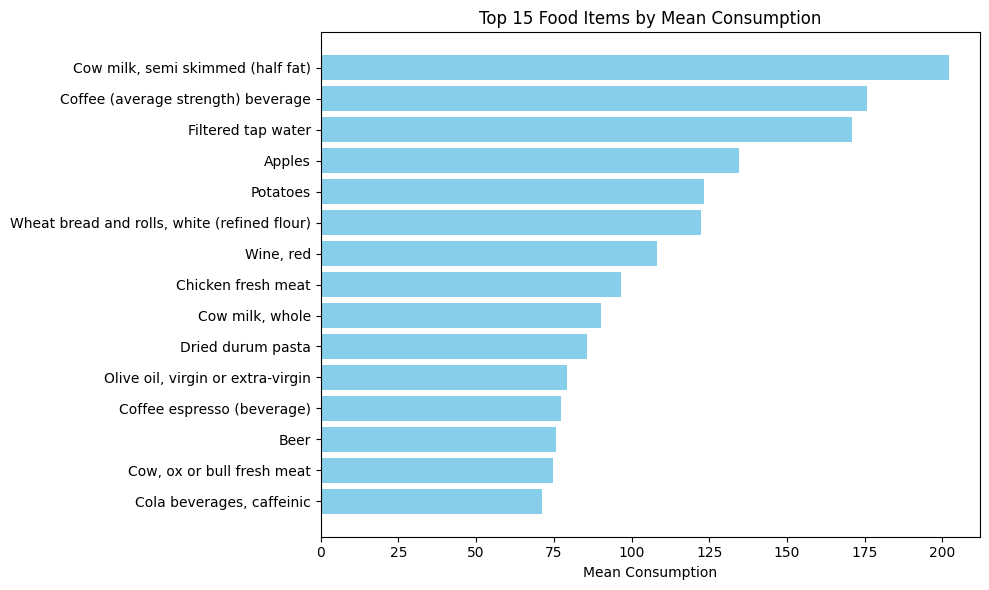

In [79]:
# Group by 'Exposure hierarchy (L7)', sum the 'Mean' values, and get the top 15
food_consumption_data_nowater = food_consumption_data[
    (food_consumption_data["Exposure hierarchy (L7)"] != "Natural mineral water") &
    (food_consumption_data["Exposure hierarchy (L7)"] != "Tap water")]

top15 = (
    food_consumption_data_nowater
    .groupby('Exposure hierarchy (L7)', as_index=False)['Mean']
    .sum()
    .sort_values('Mean', ascending=False)
    .head(15)
)

# Extract lists
selected_variables = top15["Exposure hierarchy (L7)"].tolist()
selected_values = top15["Mean"].tolist()

# Create a bar plot for the top 15 food items
plt.figure(figsize=(10, 6))
plt.barh(selected_variables, selected_values, color='skyblue')
plt.xlabel('Mean Consumption')
plt.title('Top 15 Food Items by Mean Consumption')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
plt.tight_layout()
plt.show()

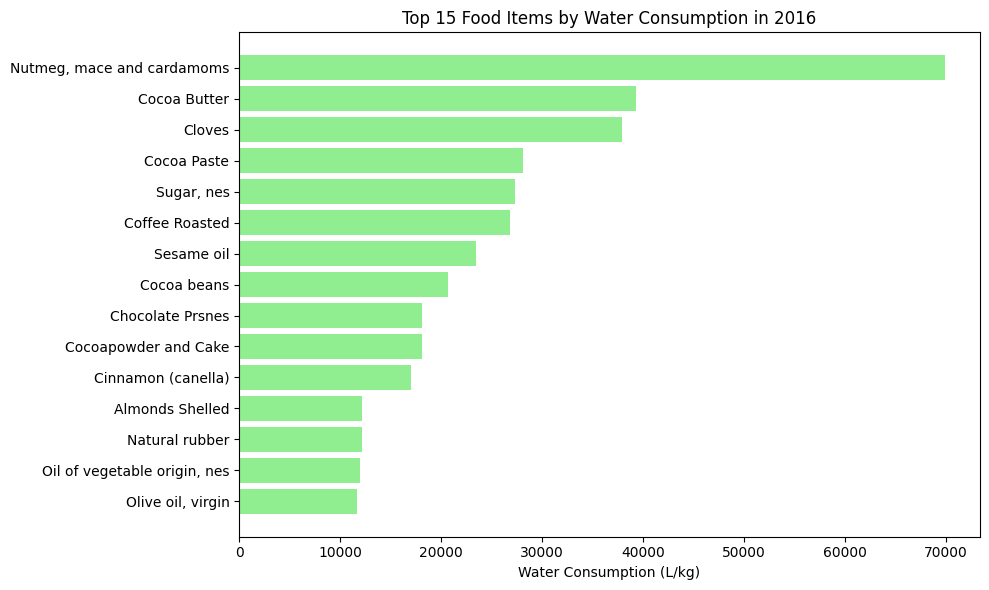

In [80]:
# Select the top 15 rows with the highest values in the "2016" column
top15_2016 = (
    watertofood_data[["Item Name", "2016"]]
    .sort_values("2016", ascending=False)
    .head(15)
    .reset_index(drop=True)
)

selected_variables = top15_2016["Item Name"].tolist()
selected_values = top15_2016["2016"].tolist()

# Create a bar plot for the top 15 food items in 2016
plt.figure(figsize=(10, 6))
plt.barh(selected_variables, selected_values, color='lightgreen')
plt.xlabel('Water Consumption (L/kg)')
plt.title('Top 15 Food Items by Water Consumption in 2016')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value
plt.tight_layout()
plt.show()

In [ ]:
# Search for matches between 'Item Name' in watertofood_data and 'Exposure hierarchy (L7)' in food_consumption_data
# Create a list to store matches
matches = []

# Lowercase exposure values for matching
exposure_values = food_consumption_data['Exposure hierarchy (L7)'].astype(str).str.lower().unique()

for item in watertofood_data['Item Name']:
    item_lower = str(item).lower()
    for exposure in exposure_values:
        # Check for exact or partial match
        if exposure in item_lower or item_lower in exposure:
            matches.append({'Item Name': item, 'Exposure hierarchy (L7)': exposure})
            break  # Stop at first match

# Create the resulting DataFrame
matches_df = pd.DataFrame(matches)

# Display all rows with columns side by side in the console
with pd.option_context('display.max_rows', None, 'display.width', None):
    print(matches_df.to_string(index=False))

In [ ]:
# Search for correspondence between top 15 exposures and Item Name in watertofood_data
# Prepare a list of Item Name values
item_names = watertofood_data['Item Name'].astype(str).tolist()

results = []

for exposure in top15['Exposure hierarchy (L7)']:
    # Find the best match in Item Name for each exposure value
    match, score = process.extractOne(str(exposure), item_names)
    # Set a threshold for match quality (e.g., 70)
    if score >= 70:
        # Get the corresponding row for the matched Item Name
        matched_row = watertofood_data[watertofood_data['Item Name'] == match].iloc[0]
        results.append({
            'Exposure hierarchy (L7)': exposure,
            'Item Name': match,
            '2016': matched_row['2016']
        })

# Create the resulting DataFrame
correspondence_df = pd.DataFrame(results)

print(correspondence_df)

In [ ]:
# Search for correspondence between top 15 exposures and Item Name in watertofood_animals
# Preprocessing function
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.replace('skm', 'skimmed')  # Expand abbreviation
    text = ' '.join(text.split())  # Remove extra whitespace
    return text

# Preprocess Item Name values and keep mapping to original
watertofood_animals['Item Name Preprocessed'] = watertofood_animals['Item Name'].apply(preprocess)
item_names_animal = watertofood_animals['Item Name Preprocessed'].tolist()

results = []

for exposure in top15['Exposure hierarchy (L7)']:
    exposure_preprocessed = preprocess(exposure)
    # Find the best match in preprocessed Item Name for each preprocessed exposure value
    match, score = process.extractOne(exposure_preprocessed, item_names_animal, scorer=fuzz.token_sort_ratio)
    if score >= 70:
        # Get the corresponding row for the matched preprocessed Item Name
        matched_row = watertofood_animals[watertofood_animals['Item Name Preprocessed'] == match].iloc[0]
        results.append({
            'Exposure hierarchy (L7)': exposure,
            'Item Name': matched_row['Item Name'],
            'Value': matched_row['Value']
        })

# Create the resulting DataFrame
correspondence_animals_df = pd.DataFrame(results)

print(correspondence_animals_df)